# 时间序列数据建模流程范例
国内的新冠肺炎疫情从发现至今已经持续3个多月了，这场起源于吃野味的灾难给大家的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

那么国内的新冠肺炎疫情何时结束呢？什么时候我们才可以重获自由呢？

本篇文章将利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测。
<img src='./data/疫情前后对比.png'>

### 一，准备数据

<!-- #region -->


本文的数据集取自tushare，获取该数据集的方法参考了以下文章。

《https://zhuanlan.zhihu.com/p/109556102》
<img src="./data/1-4-新增人数.png">

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

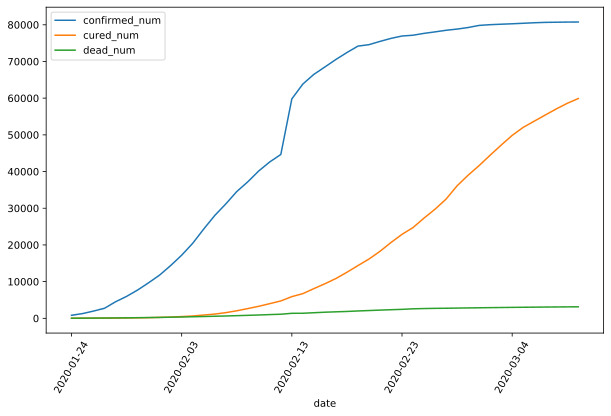

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)

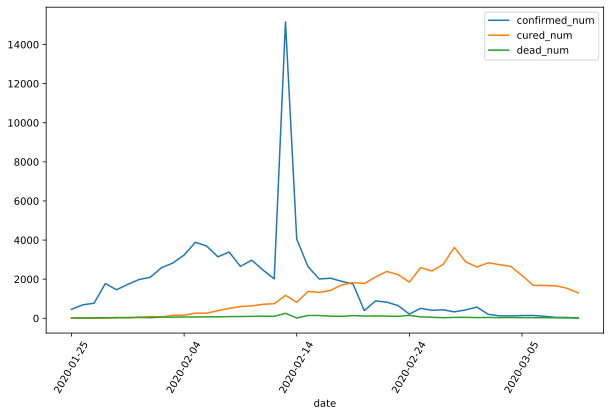

In [3]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [4]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()


### 二，定义模型


使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建任意结构模型。

In [5]:
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config


In [6]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

### 三，训练模型


训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。

In [7]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config


In [8]:
import datetime
import os

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(".\\data\\keras_model",current_time)

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 8s 8s/step - loss: 3.3592
Epoch 2/500
1/1 [==============================] - 0s 245ms/step - loss: 3.2057
Epoch 3/500
1/1 [==============================] - 0s 103ms/step - loss: 3.0463
Epoch 4/500
1/1 [==============================] - 0s 100ms/step - loss: 2.8786
Epoch 5/500
1/1 [==============================] - 0s 95ms/step - loss: 2.7016
Epoch 6/500
1/1 [==============================] - 0s 100ms/step - loss: 2.5145
Epoch 7/500
1/1 [==============================] - 0s 113ms/step - loss: 2.3169
Epoch 8/500
1/1 [==============================] - 0s 98ms/step - loss: 2.1090
Epoch 9/500
1/1 [==============================] - 0s 99ms/step - loss: 1.8919
Epoch 10/500
1/1 [==============================] - 0s 194ms/step - loss: 1.6681
Epoch 11/500
1/1 [==============================] - 0s 94ms/step - loss: 1.4420
Epoch 12/500
1/1 [==============================] - 0s 99ms/step - loss: 1.2206
Epoch 13/500
1/1 [===========================

1/1 [==============================] - 0s 123ms/step - loss: 0.3788
Epoch 102/500
1/1 [==============================] - 0s 128ms/step - loss: 0.3788
Epoch 103/500
1/1 [==============================] - 0s 107ms/step - loss: 0.3788
Epoch 104/500
1/1 [==============================] - 0s 143ms/step - loss: 0.3788
Epoch 105/500
1/1 [==============================] - 0s 123ms/step - loss: 0.3788
Epoch 106/500
1/1 [==============================] - 0s 111ms/step - loss: 0.3788
Epoch 107/500
1/1 [==============================] - 0s 104ms/step - loss: 0.3788
Epoch 108/500
1/1 [==============================] - 0s 138ms/step - loss: 0.3788
Epoch 109/500
1/1 [==============================] - 0s 254ms/step - loss: 0.3788
Epoch 110/500
1/1 [==============================] - 0s 134ms/step - loss: 0.3788
Epoch 111/500
1/1 [==============================] - 0s 119ms/step - loss: 0.3788
Epoch 112/500
1/1 [==============================] - 0s 118ms/step - loss: 0.3788
Epoch 113/500
1/1 [===========

Epoch 202/500
1/1 [==============================] - 0s 125ms/step - loss: 0.3788
Epoch 203/500
1/1 [==============================] - 0s 104ms/step - loss: 0.3788
Epoch 204/500
1/1 [==============================] - 0s 115ms/step - loss: 0.3788
Epoch 205/500
1/1 [==============================] - 0s 113ms/step - loss: 0.3788
Epoch 206/500
1/1 [==============================] - 0s 115ms/step - loss: 0.3788
Epoch 207/500
1/1 [==============================] - 0s 114ms/step - loss: 0.3788
Epoch 208/500
1/1 [==============================] - 0s 82ms/step - loss: 0.3788
Epoch 209/500
1/1 [==============================] - 0s 131ms/step - loss: 0.3788
Epoch 210/500
1/1 [==============================] - 0s 247ms/step - loss: 0.3788
Epoch 211/500
1/1 [==============================] - 0s 98ms/step - loss: 0.3788
Epoch 212/500
1/1 [==============================] - 0s 107ms/step - loss: 0.3788
Epoch 213/500
1/1 [==============================] - 0s 105ms/step - loss: 0.3788
Epoch 214/500
1/1 

Epoch 303/500
1/1 [==============================] - 0s 108ms/step - loss: 0.3788
Epoch 304/500
1/1 [==============================] - 0s 118ms/step - loss: 0.3788
Epoch 305/500
1/1 [==============================] - 0s 110ms/step - loss: 0.3788
Epoch 306/500
1/1 [==============================] - 0s 121ms/step - loss: 0.3788
Epoch 307/500
1/1 [==============================] - 0s 103ms/step - loss: 0.3788
Epoch 308/500
1/1 [==============================] - 0s 109ms/step - loss: 0.3788
Epoch 309/500
1/1 [==============================] - 0s 110ms/step - loss: 0.3788
Epoch 310/500
1/1 [==============================] - 0s 118ms/step - loss: 0.3788
Epoch 311/500
1/1 [==============================] - 0s 206ms/step - loss: 0.3788
Epoch 312/500
1/1 [==============================] - 0s 113ms/step - loss: 0.3788
Epoch 313/500
1/1 [==============================] - 0s 130ms/step - loss: 0.3788
Epoch 314/500
1/1 [==============================] - 0s 125ms/step - loss: 0.3788
Epoch 315/500
1/

### 四，评估模型


评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()


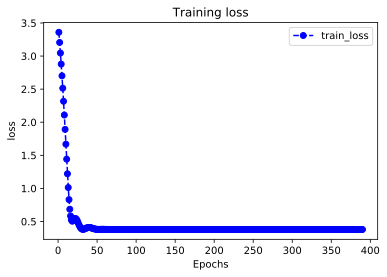

In [10]:
plot_metric(history,"loss")

### 五，使用模型


此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [11]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [12]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [13]:
dfresult.query("confirmed_num==0").head()

# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
49,0.0,1199.0,0.0
50,0.0,1178.0,0.0
51,0.0,1158.0,0.0
52,0.0,1139.0,0.0
53,0.0,1121.0,0.0


In [15]:
dfresult.query("cured_num==0").head()

# 第164天开始新增治愈降为0，第45天对应3月10日，也就是大概4个月后，即7月10日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num


<img src="./data/1-4-预测治愈.png">

In [16]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
47,3.0,1245.0,0.0
48,1.0,1221.0,0.0
49,0.0,1199.0,0.0
50,0.0,1178.0,0.0
51,0.0,1158.0,0.0


<img src="./data/1-4-预测死亡.png">

### 六，保存模型


推荐使用TensorFlow原生方式保存模型。

In [17]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel\assets
export saved model.


In [18]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1.10418066e+03, 8.77097855e+01, 4.04874420e+00],
       [1.36194556e+03, 6.87724457e+01, 8.23244667e+00],
       [1.48609351e+03, 1.46515198e+02, 7.69261456e+00],
       [1.70072229e+03, 1.56482224e+02, 8.63732147e+00],
       [2.04423340e+03, 2.59142548e+02, 8.77227974e+00],
       [1.94323169e+03, 2.60139252e+02, 9.85194492e+00],
       [1.65337769e+03, 3.85723694e+02, 9.85194492e+00],
       [1.78068201e+03, 5.08318054e+02, 1.16064005e+01],
       [1.39508679e+03, 5.97024536e+02, 1.20112753e+01],
       [1.56394910e+03, 6.29915710e+02, 1.30909405e+01],
       [1.29776733e+03, 7.12641968e+02, 1.45754795e+01],
       [1.05999243e+03, 7.41546326e+02, 1.30909405e+01],
       [7.97019580e+03, 1.16713818e+03, 3.42793694e+01],
       [2.12892749e+03, 8.09322083e+02, 1.75445592e+00],
       [1.38930017e+03, 1.36847192e+03, 1.92990150e+01],
       [1.05631006e+03, 1.31863684e+03, 1.91640568e+01],
       [1.07735205e+03, 1.42030042e+03, 1.41706057e+01],
       [9.93183899e+02, 1.70236